### *This file allows to initialize a STG spiking neuron as well as neuromodulating them in a robust way with a controller*

# **Useful packages and functions**

In [34]:
using DifferentialEquations, Plots, Plots.PlotMeasures, LaTeXStrings, Random, Dierckx, DelimitedFiles
include("STG_kinetics.jl") # Loading of STG kinetics of gating variables
include("STG_models.jl") # Loading of STG model
include("STG_utils.jl") # Loading of some utils functions
include("STG_gs_derivatives.jl") # Loading of X_inf derivatives
include("STG_DIC.jl") # Loading of the DIC and compensation algorithm
include("STG_neuromodulation.jl") # Loading of the neuromodulation cells functions
include("STG_large_simulations.jl"); # Loading of the neuromodulation cells functions

# **Global variables**

In [35]:
# Definition of simulation time (in ms)
const Tfinal = 300000
const tspan  = (0.0, Tfinal)

# Definition of reversal potential values (in mV) and membrane capacitance
const VNa   = 50. # Sodium reversal potential
const VK    = -80. # Potassium reversal potential
const VCa   = 80. # Calcium reversal potential
const VH    = -20. # Reversal potential for the H-current (permeable to both sodium and potassium ions)
const Vleak = -50. # Reversal potential of leak channels
const C     = 1. # Membrane capacitance

# Definition of voltage range for the DICs
const Vmin = -60 
const Vmax = 0
const V    = range(Vmin, stop=Vmax, step=0.01)

# Definition of the number of cells in the random set
const ncells = 200

# Modifying backend GR attributes
gr(guidefontsize=18, legendfontsize=12, margin=5Plots.mm, grid=false)
myApple = RGBA(187/255, 206/255, 131/255, 1)
mySalmon = RGBA(243/255, 124/255, 130/255)
myYellow = RGBA(228/255, 205/255, 121/255, 1)
myBlue = RGBA(131/255, 174/255, 218/255, 1)
myDarkBlue = RGBA(114/255, 119/255, 217/255, 1)
myOrange = RGBA(241/255, 175/255, 113/255, 1)
myPink = RGBA(243/255, 124/255, 130/255, 1)
myPurple = RGBA(169/255, 90/255, 179/255, 1)
myGreen = RGBA(132/255, 195/255, 168/255, 1)
myRed = RGBA(158/255, 3/255, 8/255, 1)
myGray = RGBA(150/255, 150/255, 150/255, 1)
myLightBlue = RGBA(127/255, 154/255, 209/255, 1)
default(fmt = :png)

# Moving average function
moving_average(vs, n, padding) = [sum(vs[i:(i+n-1)])/n for i in 1:padding:(length(vs)-(n-1))];

# **Neuromodulation gCaS and gA overall**

## **Computation of gCaS and gA**

In [36]:
# Fixing random seed
Random.seed!(544)

# Initial firing pattern
guth = 4.
Vth = -50.
(g_all_init, ICs_th_init) = degeneracy_fixDICs_neuromod(ncells, 5., guth, Vth);
# create a spiking set with max variability in gCaS and gA

In [37]:
# Definition of parameters
α = 5e-3 # Rate of transfer between intracellular and membrane
β = 5e-3 # Rate of degradation of intracellular proteins
Kp = 3e-4 # Proprtional gain
Ki = 5e-6 # Integral gain
Kt = β / Ki # Anti-windup gain
gsth_sim(t) = -8. # Reference
guth_sim(t) = 4.
u_maxCaS = 1e7 # Maximum value of actuator
u_maxA = 1e7

# Definition of homeostatic parameters
tau_g = 100 # Conductance time constant
tau_Na = 600 # Sodium integral action time constants
Ca_tgt(t) = 125. # Calcium target

# Input current definition
Iapp = 0.

tt = 0. : 0.2 : Tfinal/3

window_size_s = 5
padding_s = 0.2
window_size_ = Int64(round(window_size_s*1000*length(tt)/(Tfinal/3)))
padding_ = Int64(round(padding_s*1000*length(tt)/(Tfinal/3)))
tt_moving_average_ = window_size_s/2 : padding_s : Tfinal/3000 - window_size_s/2
tt_moving_average_plot = range(0, Tfinal/3e3, length(tt_moving_average_));

In [38]:
burstiness_init = readdlm("./data/burstiness_init.dat");

In [39]:
gNa_matrix_H_blockade = readdlm("./data/gNa_matrix_H_blockade.dat")
gCaT_matrix_H_blockade = readdlm("./data/gCaT_matrix_H_blockade.dat")
gCaS_matrix_H_blockade = readdlm("./data/gCaS_matrix_H_blockade.dat")
gA_matrix_H_blockade = readdlm("./data/gA_matrix_H_blockade.dat")
gKCa_matrix_H_blockade = readdlm("./data/gKCa_matrix_H_blockade.dat")
gKd_matrix_H_blockade = readdlm("./data/gKd_matrix_H_blockade.dat")
gleak_matrix_H_blockade = readdlm("./data/gleak_matrix_H_blockade.dat")
Ca_ma_matrix_H_blockade = readdlm("./data/Ca_ma_matrix_H_blockade.dat")
burstiness_before_H_blockade = readdlm("./data/burstiness_before_H_blockade.dat")
burstiness_after_H_blockade = readdlm("./data/burstiness_after_H_blockade.dat");

In [40]:
gNa_matrix_CaT_blockade = readdlm("./data/gNa_matrix_CaT_blockade.dat")
gCaS_matrix_CaT_blockade = readdlm("./data/gCaS_matrix_CaT_blockade.dat")
gA_matrix_CaT_blockade = readdlm("./data/gA_matrix_CaT_blockade.dat")
gKCa_matrix_CaT_blockade = readdlm("./data/gKCa_matrix_CaT_blockade.dat")
gKd_matrix_CaT_blockade = readdlm("./data/gKd_matrix_CaT_blockade.dat")
gH_matrix_CaT_blockade = readdlm("./data/gH_matrix_CaT_blockade.dat")
gleak_matrix_CaT_blockade = readdlm("./data/gleak_matrix_CaT_blockade.dat")
Ca_ma_matrix_CaT_blockade = readdlm("./data/Ca_ma_matrix_CaT_blockade.dat")
burstiness_before_CaT_blockade = readdlm("./data/burstiness_before_CaT_blockade.dat")
burstiness_after_CaT_blockade = readdlm("./data/burstiness_after_CaT_blockade.dat");

In [41]:
gCaT_matrix_Na_blockade = readdlm("./data/gCaT_matrix_Na_blockade.dat")
gCaS_matrix_Na_blockade = readdlm("./data/gCaS_matrix_Na_blockade.dat")
gA_matrix_Na_blockade = readdlm("./data/gA_matrix_Na_blockade.dat")
gKCa_matrix_Na_blockade = readdlm("./data/gKCa_matrix_Na_blockade.dat")
gKd_matrix_Na_blockade = readdlm("./data/gKd_matrix_Na_blockade.dat")
gH_matrix_Na_blockade = readdlm("./data/gH_matrix_Na_blockade.dat")
gleak_matrix_Na_blockade = readdlm("./data/gleak_matrix_Na_blockade.dat")
Ca_ma_matrix_Na_blockade = readdlm("./data/Ca_ma_matrix_Na_blockade.dat")
burstiness_before_Na_blockade = readdlm("./data/burstiness_before_Na_blockade.dat")
burstiness_after_Na_blockade = readdlm("./data/burstiness_after_Na_blockade.dat");

In [42]:
gNa_matrix_KCa_blockade = readdlm("./data/gNa_matrix_KCa_blockade.dat")
gCaT_matrix_KCa_blockade = readdlm("./data/gCaT_matrix_KCa_blockade.dat")
gCaS_matrix_KCa_blockade = readdlm("./data/gCaS_matrix_KCa_blockade.dat")
gA_matrix_KCa_blockade = readdlm("./data/gA_matrix_KCa_blockade.dat")
gKd_matrix_KCa_blockade = readdlm("./data/gKd_matrix_KCa_blockade.dat")
gH_matrix_KCa_blockade = readdlm("./data/gH_matrix_KCa_blockade.dat")
gleak_matrix_KCa_blockade = readdlm("./data/gleak_matrix_KCa_blockade.dat")
Ca_ma_matrix_KCa_blockade = readdlm("./data/Ca_ma_matrix_KCa_blockade.dat")
burstiness_before_KCa_blockade = readdlm("./data/burstiness_before_KCa_blockade.dat")
burstiness_after_KCa_blockade = readdlm("./data/burstiness_after_KCa_blockade.dat");

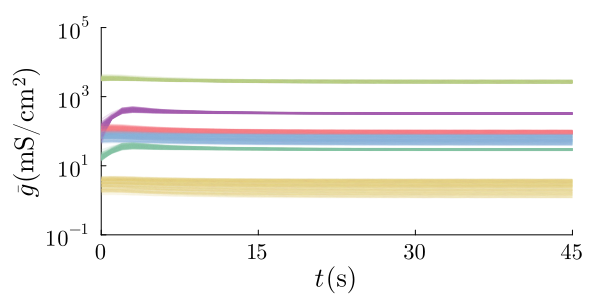

"C:\\Users\\arthu\\GitHub repositories\\BIOCONTROL_2025\\figure 4\\figures\\g_all_H_blockade.pdf"

In [50]:
p1 = plot(ylims=(1e-1, 1e5), yticks=([1e-1, 1e1, 1e3, 1e5], [L"10^{-1}", L"10^{1}", L"10^{3}", L"10^{5}"]), 
          guidefontsize=18, xticks=([0, 15, 30, 45], [L"0", L"15", L"30", L"45"]), tickfontsize=15, 
          size=(600, 300), xlims=(0, 45))

xlabel!(L"t\,\mathrm{(s)}")
ylabel!(L"\bar{g}\,\mathrm{(mS/cm^2)}")

for i = 1 : ncells
    plot!(tt[2:5000:end]./1e3, gNa_matrix_H_blockade[i, :], color=myApple, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gCaT_matrix_H_blockade[i, :], color=myYellow, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gA_matrix_H_blockade[i, :], color=myPurple, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gCaS_matrix_H_blockade[i, :], color=myGreen, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gKCa_matrix_H_blockade[i, :], color=myBlue, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gKd_matrix_H_blockade[i, :], color=myPink, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
#     plot!(tt[2:5000:end]./1e3, gH_matrix_H_blockade[i, :], color=myOrange, linewidth=1.5,
#           legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gleak_matrix_H_blockade[i, :], color=myDarkBlue, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
end

display(p1)
# savefig(p1, "./figures/g_all_H_blockade.pdf")

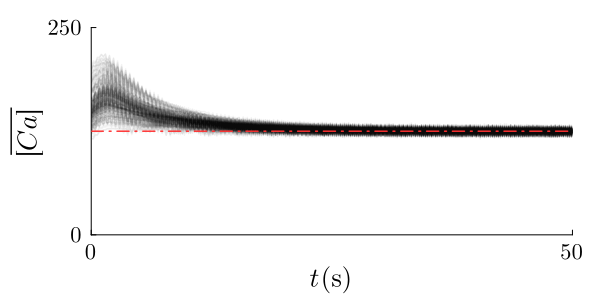

In [34]:
p1b = plot(size=(600, 300), ylims=(0, 250), yticks=([0, 250], [L"0", L"250"]), 
           xlims=(0, 50), guidefontsize=18, xticks=([0, 50], [L"0", L"50"]), tickfontsize=15)

ylabel!(L"\overline{[Ca]}")
xlabel!(L"t\,\mathrm{(s)}")

for i = 1 : ncells
    plot!(tt_moving_average_plot, Ca_ma_matrix_H_blockade[i, :], linewidth=1.5, color=:black, 
          alpha=0.05, legend=false)
end

plot!([0, 50], [125, 125], color=:firebrick1, linestyle=:dashdot, linewidth=1.5)

display(p1b)
# savefig(p1b, "./figures/Ca_ma_H_blockade.pdf")

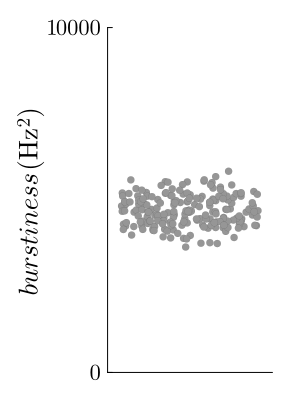

In [24]:
Random.seed!(2022)
p2b = scatter(rand(ncells), burstiness_before_H_blockade, label="", color=myGray, grid=false,
             yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm,
             markerstrokewidth=0., yticks=([0, 10000], [L"0", L"10000"]), tickfontsize=15, 
             xticks=false, size=(300, 400))

ylabel!(L"burstiness\,\mathrm{(Hz^2)}")
xlims!((-0.1, 1.1))
ylims!((0, 10000))
display(p2b)
# savefig(p2b, "./figures/STG_burstiness_before_H_blockade.pdf")

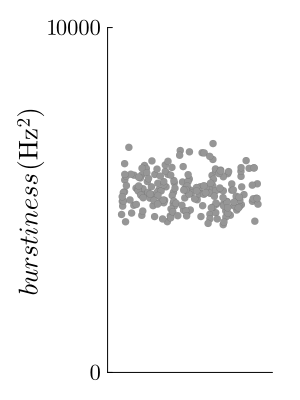

In [26]:
Random.seed!(2022)
p2b = scatter(rand(ncells), burstiness_after_H_blockade, label="", color=myGray, grid=false,
             yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm,
             markerstrokewidth=0., yticks=([0, 10000], [L"0", L"10000"]), tickfontsize=15, 
             xticks=false, size=(300, 400))

ylabel!(L"burstiness\,\mathrm{(Hz^2)}")
xlims!((-0.1, 1.1))
ylims!((0, 10000))
display(p2b)
# savefig(p2b, "./figures/STG_burstiness_after_H_blockade.pdf")

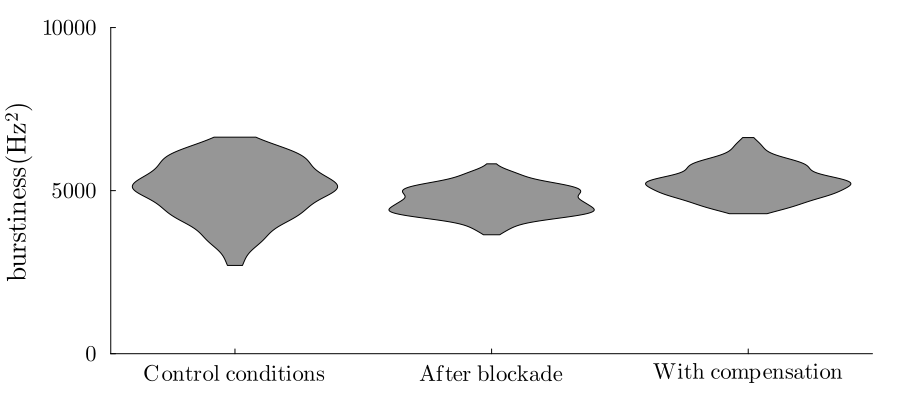

In [26]:
violins_H = violin([burstiness_init, burstiness_before_H_blockade, burstiness_after_H_blockade], 
                   label="", color=myGray, grid=false, yguidefontsize=18, xguidefontsize=18, 
                   legendfontsize=12, margin=5Plots.mm, markerstrokewidth=0., yticks=([0, 5000, 10000], 
                   [L"0", L"5000", L"10000"]), tickfontsize=15,  size=(900, 400),
                   xticks=([1, 2, 3], [L"\mathrm{Control\ conditions}", 
                   L"\mathrm{After\ blockade}", L"\mathrm{With\ compensation}"]))

ylabel!(L"\mathrm{burstiness}\,\mathrm{(Hz^2)}")
ylims!((0, 10000))
display(violins_H)
# savefig(violins_H, "./figures/violins_H_blockade.pdf")

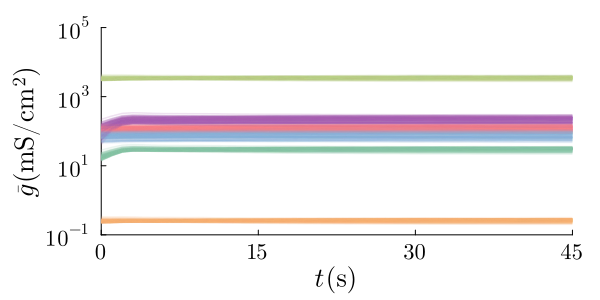

"C:\\Users\\arthu\\GitHub repositories\\BIOCONTROL_2025\\figure 4\\figures\\g_all_CaT_blockade.pdf"

In [51]:
p2 = plot(ylims=(1e-1, 1e5), yticks=([1e-1, 1e1, 1e3, 1e5], [L"10^{-1}", L"10^{1}", L"10^{3}", L"10^{5}"]), 
          guidefontsize=18, xticks=([0, 15, 30, 45], [L"0", L"15", L"30", L"45"]), tickfontsize=15, 
          size=(600, 300), xlims=(0, 45))

xlabel!(L"t\,\mathrm{(s)}")
ylabel!(L"\bar{g}\,\mathrm{(mS/cm^2)}")

for i = 1 : ncells
    plot!(tt[2:5000:end]./1e3, gNa_matrix_CaT_blockade[i, :], color=myApple, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
#     plot!(tt[2:5000:end]./1e3, gCaT_matrix_CaT_blockade[i, :], color=myYellow, linewidth=1.5,
#           legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gA_matrix_CaT_blockade[i, :], color=myPurple, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gCaS_matrix_CaT_blockade[i, :], color=myGreen, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gKCa_matrix_CaT_blockade[i, :], color=myBlue, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gKd_matrix_CaT_blockade[i, :], color=myPink, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gH_matrix_CaT_blockade[i, :], color=myOrange, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gleak_matrix_CaT_blockade[i, :], color=myDarkBlue, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
end

display(p2)
# savefig(p2, "./figures/g_all_CaT_blockade.pdf")

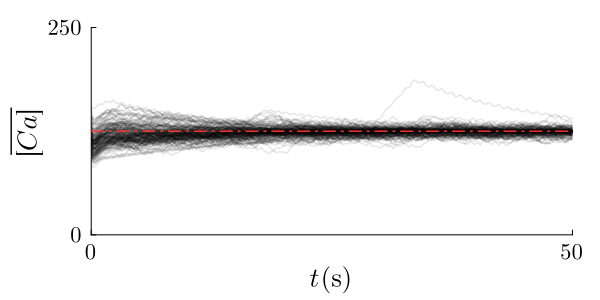

In [42]:
p2b = plot(size=(600, 300), ylims=(0, 250), yticks=([0, 250], [L"0", L"250"]), 
           xlims=(0, 50), guidefontsize=18, xticks=([0, 50], [L"0", L"50"]), tickfontsize=15)

ylabel!(L"\overline{[Ca]}")
xlabel!(L"t\,\mathrm{(s)}")

for i = 1 : ncells
    plot!(tt_moving_average_plot, Ca_ma_matrix_CaT_blockade[i, :], linewidth=1.5, color=:black, 
          alpha=0.1, legend=false)
end

plot!([0, 50], [125, 125], color=:firebrick1, linestyle=:dashdot, linewidth=1.5)

display(p2b)
# savefig(p2b, "./figures/Ca_ma_CaT_blockade.pdf")

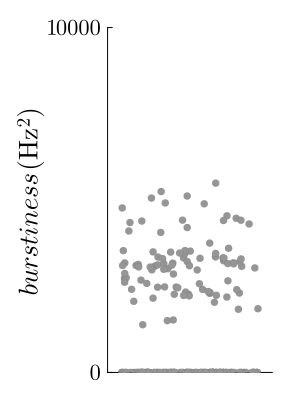

In [28]:
Random.seed!(2022)
burstiness_before_CaT_blockade[findall(isnan.(burstiness_before_CaT_blockade))] .= 0
p2b = scatter(rand(ncells), burstiness_before_CaT_blockade, label="", color=myGray, grid=false,
             yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm,
             markerstrokewidth=0., yticks=([0, 10000], [L"0", L"10000"]), tickfontsize=15, 
             xticks=false, size=(300, 400))

ylabel!(L"burstiness\,\mathrm{(Hz^2)}")
xlims!((-0.1, 1.1))
ylims!((0, 10000))
display(p2b)
# savefig(p2b, "./figures/STG_burstiness_before_CaT_blockade.pdf")

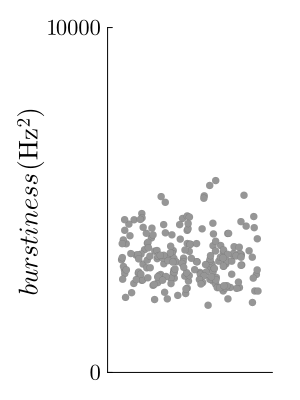

In [30]:
Random.seed!(2022)
burstiness_after_CaT_blockade[findall(isnan.(burstiness_after_CaT_blockade))] .= 0
p2b = scatter(rand(ncells), burstiness_after_CaT_blockade, label="", color=myGray, grid=false,
             yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm,
             markerstrokewidth=0., yticks=([0, 10000], [L"0", L"10000"]), tickfontsize=15, 
             xticks=false, size=(300, 400))

ylabel!(L"burstiness\,\mathrm{(Hz^2)}")
xlims!((-0.1, 1.1))
ylims!((0, 10000))
display(p2b)
# savefig(p2b, "./figures/STG_burstiness_after_CaT_blockade.pdf")

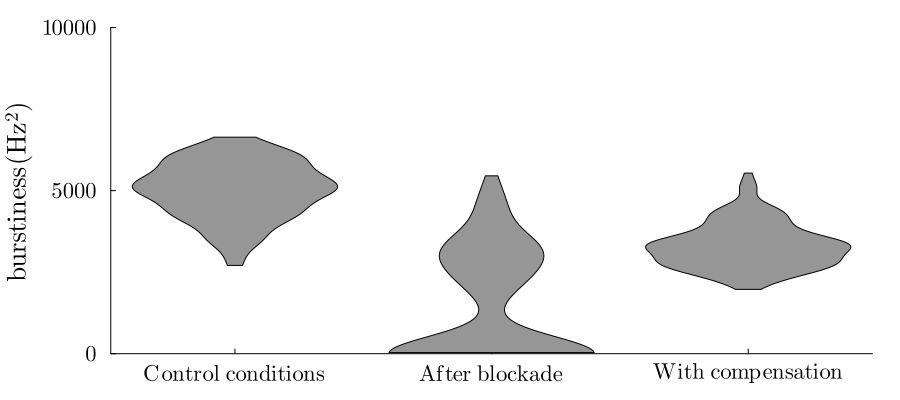

In [28]:
burstiness_before_CaT_blockade[findall(isnan.(burstiness_before_CaT_blockade))] .= 0
burstiness_after_CaT_blockade[findall(isnan.(burstiness_after_CaT_blockade))] .= 0
violins_CaT = violin([burstiness_init, burstiness_before_CaT_blockade, burstiness_after_CaT_blockade], 
                   label="", color=myGray, grid=false, yguidefontsize=18, xguidefontsize=18, 
                   legendfontsize=12, margin=5Plots.mm, markerstrokewidth=0., yticks=([0, 5000, 10000], 
                   [L"0", L"5000", L"10000"]), tickfontsize=15,  size=(900, 400),
                   xticks=([1, 2, 3], [L"\mathrm{Control\ conditions}", 
                   L"\mathrm{After\ blockade}", L"\mathrm{With\ compensation}"]))

ylabel!(L"\mathrm{burstiness}\,\mathrm{(Hz^2)}")
ylims!((0, 10000))
display(violins_CaT)
# savefig(violins_CaT, "./figures/violins_CaT_blockade.pdf")

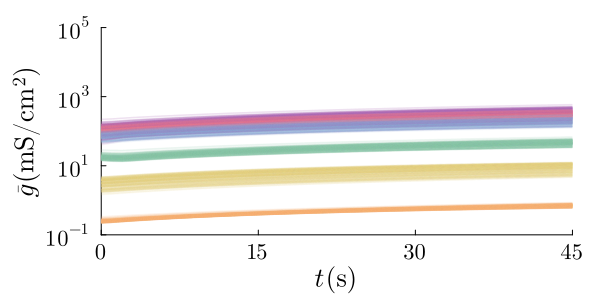

"C:\\Users\\arthu\\GitHub repositories\\BIOCONTROL_2025\\figure 4\\figures\\g_all_Na_blockade.pdf"

In [52]:
p3 = plot(ylims=(1e-1, 1e5), yticks=([1e-1, 1e1, 1e3, 1e5], [L"10^{-1}", L"10^{1}", L"10^{3}", L"10^{5}"]), 
          guidefontsize=18, xticks=([0, 15, 30, 45], [L"0", L"15", L"30", L"45"]), tickfontsize=15, 
          size=(600, 300), xlims=(0, 45))
xlabel!(L"t\,\mathrm{(s)}")
ylabel!(L"\bar{g}\,\mathrm{(mS/cm^2)}")

for i = 1 : ncells
#     plot!(tt[2:5000:end]./1e3, gNa_matrix_Na_blockade[i, :], color=myApple, linewidth=1.5,
#           legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gCaT_matrix_Na_blockade[i, :], color=myYellow, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gA_matrix_Na_blockade[i, :], color=myPurple, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gCaS_matrix_Na_blockade[i, :], color=myGreen, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gKCa_matrix_Na_blockade[i, :], color=myBlue, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gKd_matrix_Na_blockade[i, :], color=myPink, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gH_matrix_Na_blockade[i, :], color=myOrange, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gleak_matrix_Na_blockade[i, :], color=myDarkBlue, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
end

display(p3)
# savefig(p3, "./figures/g_all_Na_blockade.pdf")

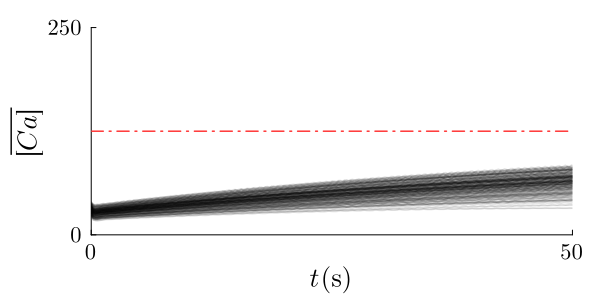

In [47]:
p3b = plot(size=(600, 300), ylims=(0, 250), yticks=([0, 250], [L"0", L"250"]), 
           xlims=(0, 50), guidefontsize=18, xticks=([0, 50], [L"0", L"50"]), tickfontsize=15)

ylabel!(L"\overline{[Ca]}")
xlabel!(L"t\,\mathrm{(s)}")

for i = 1 : ncells
    plot!(tt_moving_average_plot, Ca_ma_matrix_Na_blockade[i, :], linewidth=1.5, color=:black, 
          alpha=0.1, legend=false)
end

plot!([0, 50], [125, 125], color=:firebrick1, linestyle=:dashdot, linewidth=1.5)

display(p3b)
# savefig(p3b, "./figures/Ca_ma_Na_blockade.pdf")

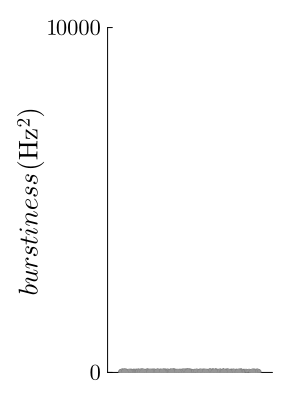

In [32]:
Random.seed!(2022)
burstiness_before_Na_blockade[findall(isnan.(burstiness_before_Na_blockade))] .= 0
p2b = scatter(rand(ncells), burstiness_before_Na_blockade, label="", color=myGray, grid=false,
             yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm,
             markerstrokewidth=0., yticks=([0, 10000], [L"0", L"10000"]), tickfontsize=15, 
             xticks=false, size=(300, 400))

ylabel!(L"burstiness\,\mathrm{(Hz^2)}")
xlims!((-0.1, 1.1))
ylims!((0, 10000))
display(p2b)
# savefig(p2b, "./figures/STG_burstiness_before_Na_blockade.pdf")

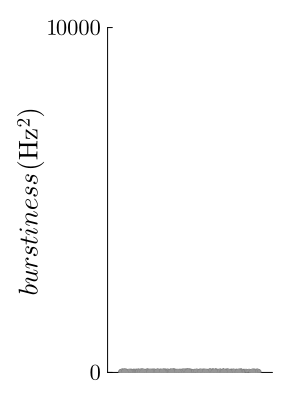

In [34]:
Random.seed!(2022)
burstiness_after_Na_blockade[findall(isnan.(burstiness_after_Na_blockade))] .= 0
p2b = scatter(rand(ncells), burstiness_after_Na_blockade, label="", color=myGray, grid=false,
             yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm,
             markerstrokewidth=0., yticks=([0, 10000], [L"0", L"10000"]), tickfontsize=15, 
             xticks=false, size=(300, 400))

ylabel!(L"burstiness\,\mathrm{(Hz^2)}")
xlims!((-0.1, 1.1))
ylims!((0, 10000))
display(p2b)
# savefig(p2b, "./figures/STG_burstiness_after_Na_blockade.pdf")

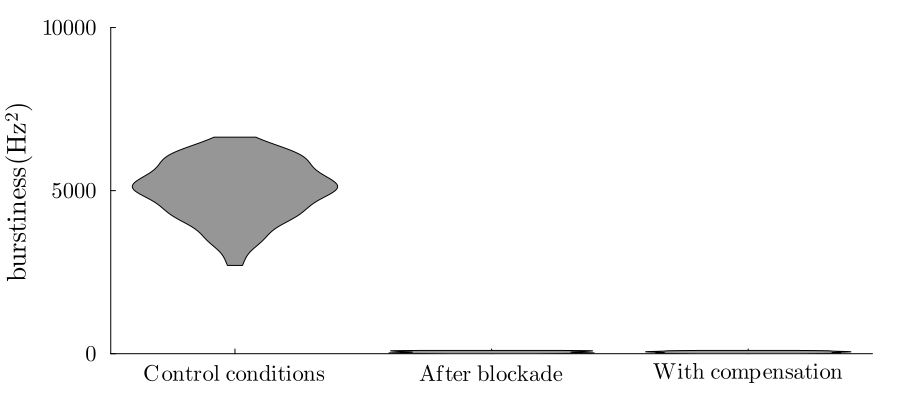

In [30]:
Random.seed!(42)
burstiness_before_Na_blockade[findall(isnan.(burstiness_before_Na_blockade))] .= 0
burstiness_after_Na_blockade[findall(isnan.(burstiness_after_Na_blockade))] .= 0
burstiness_before_Na_blockade_plot = burstiness_before_Na_blockade .+ 100*rand(200)
burstiness_after_Na_blockade_plot = burstiness_after_Na_blockade .+ 100*rand(200)
violins_Na = violin([burstiness_init, burstiness_before_Na_blockade_plot, burstiness_after_Na_blockade_plot], 
                   label="", color=myGray, grid=false, yguidefontsize=18, xguidefontsize=18, 
                   legendfontsize=12, margin=5Plots.mm, markerstrokewidth=0., yticks=([0, 5000, 10000], 
                   [L"0", L"5000", L"10000"]), tickfontsize=15,  size=(900, 400),
                   xticks=([1, 2, 3], [L"\mathrm{Control\ conditions}", 
                   L"\mathrm{After\ blockade}", L"\mathrm{With\ compensation}"]))

ylabel!(L"\mathrm{burstiness}\,\mathrm{(Hz^2)}")
ylims!((0, 10000))
display(violins_Na)
# savefig(violins_Na, "./figures/violins_Na_blockade.pdf")

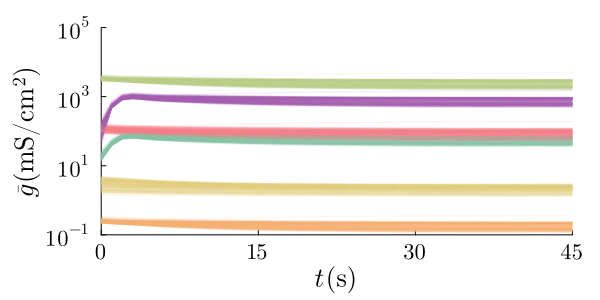

"C:\\Users\\arthu\\GitHub repositories\\BIOCONTROL_2025\\figure 4\\figures\\g_all_KCa_blockade.pdf"

In [54]:
p4 = plot(ylims=(1e-1, 1e5), yticks=([1e-1, 1e1, 1e3, 1e5], [L"10^{-1}", L"10^{1}", L"10^{3}", L"10^{5}"]), 
          guidefontsize=18, xticks=([0, 15, 30, 45], [L"0", L"15", L"30", L"45"]), tickfontsize=15, 
          size=(600, 300), xlims=(0, 45))
xlabel!(L"t\,\mathrm{(s)}")
ylabel!(L"\bar{g}\,\mathrm{(mS/cm^2)}")

for i = 1 : ncells
    plot!(tt[2:5000:end]./1e3, gNa_matrix_KCa_blockade[i, :], color=myApple, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gCaT_matrix_KCa_blockade[i, :], color=myYellow, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gA_matrix_KCa_blockade[i, :], color=myPurple, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gCaS_matrix_KCa_blockade[i, :], color=myGreen, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
#     plot!(tt[2:5000:end]./1e3, gKCa_matrix_KCa_blockade[i, :], color=myBlue, linewidth=1.5,
#           legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gKd_matrix_KCa_blockade[i, :], color=myPink, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gH_matrix_KCa_blockade[i, :], color=myOrange, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gleak_matrix_KCa_blockade[i, :], color=myDarkBlue, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
end

display(p4)
# savefig(p4, "./figures/g_all_KCa_blockade.pdf")

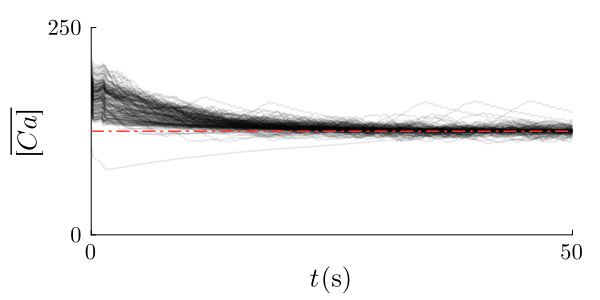

In [54]:
p4b = plot(size=(600, 300), ylims=(0, 250), yticks=([0, 250], [L"0", L"250"]), 
           xlims=(0, 50), guidefontsize=18, xticks=([0, 50], [L"0", L"50"]), tickfontsize=15)

ylabel!(L"\overline{[Ca]}")
xlabel!(L"t\,\mathrm{(s)}")

for i = 1 : ncells
    plot!(tt_moving_average_plot, Ca_ma_matrix_KCa_blockade[i, :], linewidth=1.5, color=:black, 
          alpha=0.1, legend=false)
end

plot!([0, 50], [125, 125], color=:firebrick1, linestyle=:dashdot, linewidth=1.5)

display(p4b)
# savefig(p4b, "./figures/Ca_ma_KCa_blockade.pdf")

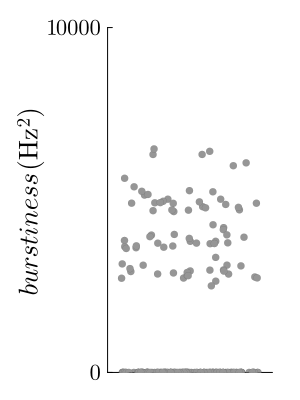

In [36]:
Random.seed!(2022)
burstiness_before_KCa_blockade[findall(isnan.(burstiness_before_KCa_blockade))] .= 0
p2b = scatter(rand(ncells), burstiness_before_KCa_blockade, label="", color=myGray, grid=false,
             yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm,
             markerstrokewidth=0., yticks=([0, 6000], [L"0", L"10000"]), tickfontsize=15, 
             xticks=false, size=(300, 400))

ylabel!(L"burstiness\,\mathrm{(Hz^2)}")
xlims!((-0.1, 1.1))
ylims!((0, 6000))
display(p2b)
# savefig(p2b, "./figures/STG_burstiness_before_KCa_blockade.pdf")

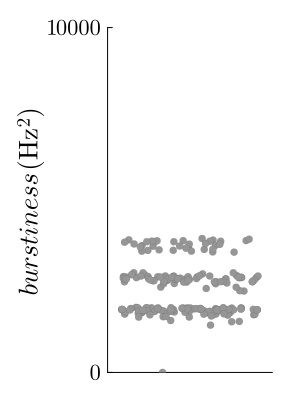

In [38]:
Random.seed!(2022)
burstiness_after_KCa_blockade[findall(isnan.(burstiness_after_KCa_blockade))] .= 0
p2b = scatter(rand(ncells), burstiness_after_KCa_blockade, label="", color=myGray, grid=false,
             yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm,
             markerstrokewidth=0., yticks=([0, 8000], [L"0", L"10000"]), tickfontsize=15, 
             xticks=false, size=(300, 400))

ylabel!(L"burstiness\,\mathrm{(Hz^2)}")
xlims!((-0.1, 1.1))
ylims!((0, 8000))
display(p2b)
# savefig(p2b, "./figures/STG_burstiness_after_KCa_blockade.pdf")

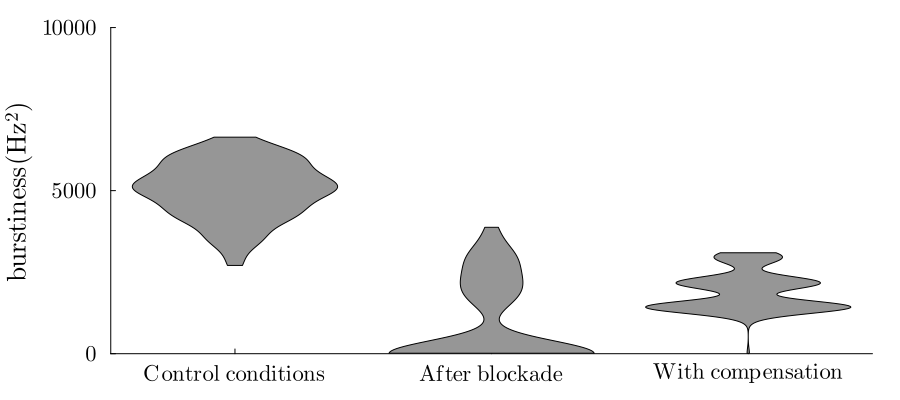

In [33]:
burstiness_before_KCa_blockade[findall(isnan.(burstiness_before_KCa_blockade))] .= 0
burstiness_after_KCa_blockade[findall(isnan.(burstiness_after_KCa_blockade))] .= 0
violins_KCa = violin([burstiness_init, burstiness_before_KCa_blockade, burstiness_after_KCa_blockade], 
                   label="", color=myGray, grid=false, yguidefontsize=18, xguidefontsize=18, 
                   legendfontsize=12, margin=5Plots.mm, markerstrokewidth=0., yticks=([0, 5000, 10000], 
                   [L"0", L"5000", L"10000"]), tickfontsize=15,  size=(900, 400),
                   xticks=([1, 2, 3], [L"\mathrm{Control\ conditions}", 
                   L"\mathrm{After\ blockade}", L"\mathrm{With\ compensation}"]))

ylabel!(L"\mathrm{burstiness}\,\mathrm{(Hz^2)}")
ylims!((0, 10000))
display(violins_KCa)
# savefig(violins_KCa, "./figures/violins_KCa_blockade.pdf")